In [1]:
# import packages
import os
import bisect
import hashlib
import json
import allel
import numpy as np
import dask
import dask.array as da
import numpy as np
from dask.diagnostics import ProgressBar
# quieten dask warnings about large chunks
dask.config.set(**{'array.slicing.split_large_chunks': True})
import pandas as pd
import malariagen_data

import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns

import random
import itertools
import scipy.stats as stats

# Abafar Setup

In [2]:
# gain access to the gateway
from dask_gateway import Gateway
gateway = Gateway()

In [3]:
for c in gateway.list_clusters():
    gateway.stop_cluster(c.name)

In [4]:
gateway.list_clusters()

[ClusterReport<name=dev.1292d43e6a4944f288addbe82d388b90, status=RUNNING>]

In [5]:
# create a cluster with the options selected via the widgets above
# ... may take a few minutes to provision a VM for the scheduler
cluster = gateway.new_cluster(environment="binder-v3.0.0", profile="Very High Memory Worker")
cluster

In [6]:
# you can scale the cluster using the widget above, or via a manual API call
# ... may take a few minutes to provision VMs for the workers
cluster.scale(20)

In [7]:
# get a client - this tells Dask to use the cluster you've just created
client = cluster.get_client()

# Functions setup

In [8]:
def load_tbl_samples_sub(subsets, seed, dataframe, max_population_size = 100):
    
    random.seed(seed)
    
    #with section('compute subset sizes'):
    subset_sizes = [len(dataframe[dataframe.population == q]) for q in subsets]
    subset_sizes.append(max_population_size)
    n = min(subset_sizes)
    #print(n)

    subsets_sidx = dict()
    for p in subsets:
        subsets_sidx[p] = sorted(random.sample(list(dataframe[dataframe.population == p].index), n))

    sidx = list(itertools.chain(*subsets_sidx.values()))
    
    return sidx, subsets_sidx

In [9]:
def load_dist_gn_balloon(chrom, site_mask, sidx, sample_sets, balloon_id):
        
    #with section('load and subset genotypes'):
    gt = allel.GenotypeDaskArray(ag3.snp_genotypes(contig=chrom, sample_sets=[sample_sets_west,"1177-VO-ML-LEHMANN-VMF00015"], site_mask=site_mask))
    genotype_sub = gt.take(sidx + [balloon_id], axis=1)
    
    
    #with section('count alleles'):
    ac_sub = genotype_sub.count_alleles(max_allele=3).compute()

    gn_dist = genotype_sub.to_n_alt()

    return gn_dist

In [10]:
def load_dist_gn(chrom, site_mask, sidx, sample_sets):
    
    #with section('load and subset genotypes'):
    gt = allel.GenotypeDaskArray(ag3.snp_genotypes(contig=chrom, sample_sets=sample_sets, site_mask=site_mask))
    genotype_sub = gt.take(sidx, axis=1)
    
    #with section('count alleles'):
    ac_sub = genotype_sub.count_alleles(max_allele=3).compute()

    gn_dist = genotype_sub.to_n_alt()

    return gn_dist

In [11]:
def comp_dist_balloon(chrom, site_mask, sidx, sample_sets, balloon_id, step=100):
    
    #with section('load doubleton genotypes'):
    gn_dbl = load_dist_gn_balloon(chrom, site_mask, sidx, sample_sets, balloon_id)
    
    #with section('count pairwise shared doubletons'):
    euc_distance = allel.pairwise_distance(gn_dbl[::step], metric='euclidean')#, chunked=True)

    return euc_distance#, gn_dbl, _dbl_count

In [12]:
def comp_dist(chrom, site_mask, sidx, sample_sets, step=100):
    
    gn_dbl = load_dist_gn(chrom, site_mask, sidx, sample_sets)
    
    euc_distance = allel.pairwise_distance(gn_dbl[::step], metric='euclidean')#, chunked=True)

    return euc_distance

# Data setup - Test 3.0 - west

In [13]:
# setup access to malariagen data in google cloud
ag3 = malariagen_data.Ag3("gs://vo_agam_release/", pre=True)

In [14]:
ag3.sample_sets(release="v3.2")

,sample_set,sample_count,release
0,1177-VO-ML-LEHMANN-VMF00015,23,v3.2
1,1237-VO-BJ-DJOGBENOU-VMF00050,90,v3.2
2,1237-VO-BJ-DJOGBENOU-VMF00067,142,v3.2
3,1244-VO-GH-YAWSON-VMF00051,666,v3.2
4,1245-VO-CI-CONSTANT-VMF00054,38,v3.2
5,1253-VO-TG-DJOGBENOU-VMF00052,179,v3.2


In [15]:
df_balloon = ag3.sample_metadata(sample_sets="1177-VO-ML-LEHMANN-VMF00015")
df_balloon = df_balloon[df_balloon.species_gambcolu_arabiensis == 'gamb_colu']
df_balloon['population'] = df_balloon['country'] + " " + df_balloon['species']
df_balloon

,sample_id,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,sample_set,release,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,species,population
0,VBS04793-4651STDY7017929,MB257 (MB2),Tovi Lehmann,Mali,Markabougou,2013,8,13.914,-6.344,F,1177-VO-ML-LEHMANN-VMF00015,v3.2,0.979,0.002,gamb_colu,coluzzii,coluzzii,Mali coluzzii
1,VBS04794-4651STDY7017930,TB615,Tovi Lehmann,Mali,Thierola,2014,9,13.659,-7.215,M,1177-VO-ML-LEHMANN-VMF00015,v3.2,0.971,0.003,gamb_colu,coluzzii,coluzzii,Mali coluzzii
2,VBS04796-4651STDY7017932,TB513 (SB513),Tovi Lehmann,Mali,Siguima,2014,8,14.168,-7.228,M,1177-VO-ML-LEHMANN-VMF00015,v3.2,0.982,0.003,gamb_colu,coluzzii,coluzzii,Mali coluzzii
3,VBS04797-4651STDY7017933,SB173 (SB3),Tovi Lehmann,Mali,Siguima,2013,8,14.168,-7.228,F,1177-VO-ML-LEHMANN-VMF00015,v3.2,0.982,0.002,gamb_colu,coluzzii,coluzzii,Mali coluzzii
4,VBS04798-4651STDY7017934,SB173 (SB4),Tovi Lehmann,Mali,Siguima,2013,8,14.168,-7.228,F,1177-VO-ML-LEHMANN-VMF00015,v3.2,0.971,0.002,gamb_colu,coluzzii,coluzzii,Mali coluzzii
5,VBS04799-4651STDY7017935,SB407,Tovi Lehmann,Mali,Siguima,2014,8,14.168,-7.228,F,1177-VO-ML-LEHMANN-VMF00015,v3.2,0.986,0.002,gamb_colu,coluzzii,coluzzii,Mali coluzzii
6,VBS04801-4651STDY7017937,SB179 (SB7),Tovi Lehmann,Mali,Siguima,2013,8,14.168,-7.228,F,1177-VO-ML-LEHMANN-VMF00015,v3.2,0.971,0.002,gamb_colu,coluzzii,coluzzii,Mali coluzzii
7,VBS04802-4651STDY7017938,SB178 (SB5),Tovi Lehmann,Mali,Siguima,2013,8,14.168,-7.228,F,1177-VO-ML-LEHMANN-VMF00015,v3.2,0.986,0.002,gamb_colu,coluzzii,coluzzii,Mali coluzzii
8,VBS04803-4651STDY7017939,DB40,Tovi Lehmann,Mali,Dallowere,2015,7,13.616,-7.037,F,1177-VO-ML-LEHMANN-VMF00015,v3.2,0.980,0.002,gamb_colu,coluzzii,coluzzii,Mali coluzzii
9,VBS04804-4651STDY7017940,TB861,Tovi Lehmann,Mali,Thierola,2015,7,13.659,-7.215,F,1177-VO-ML-LEHMANN-VMF00015,v3.2,0.966,0.002,gamb_colu,coluzzii,coluzzii,Mali coluzzii


In [16]:
sample_sets_west = ["AG1000G-CM-A", "AG1000G-CM-B", "AG1000G-CM-C",
                    "AG1000G-BF-A", "AG1000G-BF-B", "AG1000G-BF-C", "AG1000G-CI",
                    "AG1000G-CD", "AG1000G-CF", "AG1000G-GA-A",
                    "AG1000G-ML-A", "AG1000G-ML-B", "AG1000G-GH"
                    ]
df_west_all = ag3.sample_metadata(sample_sets=sample_sets_west)
df_west = df_west_all[df_west_all.species_gambcolu_arabiensis == 'gamb_colu']
df_west

,sample_id,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,sample_set,release,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,species
0,AN0007-C,CM0901778,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.027,0.002,gamb_colu,gambiae,gambiae
1,AN0008-C,CM0901779,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.021,0.002,gamb_colu,gambiae,gambiae
2,AN0009-C,CM0901780,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.022,0.002,gamb_colu,gambiae,gambiae
3,AN0010-C,CM0901782,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.015,0.002,gamb_colu,gambiae,gambiae
4,AN0011-C,CM0901783,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.017,0.002,gamb_colu,gambiae,gambiae
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,AA0135-C,Twifo_Praso__C5,David Weetman,Ghana,Twifo Praso,2012,9,5.609,-1.549,F,AG1000G-GH,v3,0.966,0.002,gamb_colu,coluzzii,coluzzii
1265,AA0124-C,Twifo_Praso__G3,David Weetman,Ghana,Twifo Praso,2012,9,5.609,-1.549,F,AG1000G-GH,v3,0.979,0.002,gamb_colu,coluzzii,coluzzii
1266,AA0045-C,Koforidua_A2,David Weetman,Ghana,Koforidua,2012,11,6.094,-0.261,F,AG1000G-GH,v3,0.035,0.002,gamb_colu,gambiae,gambiae
1267,AA0072-C,Madina_F1,David Weetman,Ghana,Madina,2012,11,5.668,-0.219,F,AG1000G-GH,v3,0.020,0.002,gamb_colu,gambiae,gambiae


In [17]:
df_west_no_balloon = ag3.sample_metadata(sample_sets=sample_sets_west)
df_all_balloon = ag3.sample_metadata(sample_sets="1177-VO-ML-LEHMANN-VMF00015")
df_all_balloon['country'] = 'Balloon'
df_all_balloon['population'] = 'Balloon'
df_all_balloon = df_all_balloon.set_index(df_all_balloon.index + 1269)
df_west_no_balloon = df_west_no_balloon[df_west_no_balloon.species_gambcolu_arabiensis == 'gamb_colu']
df_west_no_balloon['population'] = df_west_no_balloon['country'] + " " + df_west_no_balloon['species']
df_west_balloon = df_west_no_balloon.append(df_all_balloon)

In [18]:
df_west_gamb = ag3.sample_metadata(sample_sets=sample_sets_west)
df_west_gamb = df_west_gamb[df_west_gamb.species == 'gambiae']
df_west_gamb['population'] = df_west_gamb['country'] + " " + df_west_gamb['species']

In [19]:
df_west_gamb_no_balloon = ag3.sample_metadata(sample_sets=sample_sets_west)
df_gamb_balloon = ag3.sample_metadata(sample_sets="1177-VO-ML-LEHMANN-VMF00015")
df_gamb_balloon['country'] = 'Balloon'
df_gamb_balloon['population'] = 'Balloon'
df_gamb_balloon = df_gamb_balloon.set_index(df_gamb_balloon.index + 1269)
df_west_gamb_no_balloon = df_west_gamb_no_balloon[df_west_gamb_no_balloon.species == 'gambiae']
df_west_gamb_no_balloon['population'] = df_west_gamb_no_balloon['country'] + " " + df_west_gamb_no_balloon['species']
df_west_gamb_balloon = df_west_gamb_no_balloon.append(df_gamb_balloon)

In [20]:
df_west_col = ag3.sample_metadata(sample_sets=sample_sets_west)
df_west_col = df_west_col[df_west_col.species == 'coluzzii']
df_west_col['population'] = df_west_col['country'] + " " + df_west_col['species']

In [21]:
df_west_col_no_balloon = ag3.sample_metadata(sample_sets=sample_sets_west)
df_col_balloon = ag3.sample_metadata(sample_sets="1177-VO-ML-LEHMANN-VMF00015")
df_col_balloon['country'] = 'Balloon'
df_col_balloon['population'] = 'Balloon'
df_col_balloon = df_col_balloon.set_index(df_col_balloon.index + 1269)
df_west_col_no_balloon = df_west_col_no_balloon[df_west_col_no_balloon.species == 'coluzzii']
df_west_col_no_balloon['population'] = df_west_col_no_balloon['country'] + " " + df_west_col_no_balloon['species']
df_west_col_balloon = df_west_col_no_balloon.append(df_col_balloon)

In [22]:
len(df_west_all)

1269

In [23]:

df_west_balloon

,sample_id,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,sample_set,release,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,species,population
0,AN0007-C,CM0901778,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.027,0.002,gamb_colu,gambiae,gambiae,Cameroon gambiae
1,AN0008-C,CM0901779,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.021,0.002,gamb_colu,gambiae,gambiae,Cameroon gambiae
2,AN0009-C,CM0901780,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.022,0.002,gamb_colu,gambiae,gambiae,Cameroon gambiae
3,AN0010-C,CM0901782,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.015,0.002,gamb_colu,gambiae,gambiae,Cameroon gambiae
4,AN0011-C,CM0901783,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.017,0.002,gamb_colu,gambiae,gambiae,Cameroon gambiae
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,VBS04815-4651STDY7017953,MB261 (MB3),Tovi Lehmann,Balloon,Markabougou,2013,8,13.914,-6.344,F,1177-VO-ML-LEHMANN-VMF00015,v3.2,0.977,0.002,gamb_colu,coluzzii,coluzzii,Balloon
1288,VBS04816-4651STDY7017954,TB870,Tovi Lehmann,Balloon,Thierola,2015,7,13.659,-7.215,F,1177-VO-ML-LEHMANN-VMF00015,v3.2,0.983,0.002,gamb_colu,coluzzii,coluzzii,Balloon
1289,VBS04817-4651STDY7017955,SB662,Tovi Lehmann,Balloon,Siguima,2015,7,14.168,-7.228,F,1177-VO-ML-LEHMANN-VMF00015,v3.2,0.981,0.002,gamb_colu,coluzzii,coluzzii,Balloon
1290,VBS04818-4651STDY7017956,SB417,Tovi Lehmann,Balloon,Siguima,2014,9,14.168,-7.228,F,1177-VO-ML-LEHMANN-VMF00015,v3.2,0.971,0.002,gamb_colu,coluzzii,coluzzii,Balloon


In [24]:
df_west['population'] = df_west['country'] + " " + df_west['species']

/home/conda/store/fa66bfdc216f5ed0ab08df3737cd88ec3ade92502c346ef45612bbd443c36929-abafar-20210701a/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
df_west_pop_counts = df_west.population.value_counts()
df_west_pop_counts

Cameroon gambiae                              416
Burkina Faso gambiae                          157
Burkina Faso coluzzii                         135
Cote d'Ivoire coluzzii                         80
Democratic Republic of Congo gambiae           76
Gabon gambiae                                  69
Mali gambiae                                   66
Ghana coluzzii                                 64
Mali coluzzii                                  63
Central African Republic gambiae               55
Ghana gambiae                                  36
Cameroon coluzzii                              26
Central African Republic coluzzii              18
Burkina Faso intermediate_gambiae_coluzzii      1
Name: population, dtype: int64

In [26]:
df_west_balloon_pop_counts = df_west_balloon.population.value_counts()
df_west_balloon_pop_counts

Cameroon gambiae                              416
Burkina Faso gambiae                          157
Burkina Faso coluzzii                         135
Cote d'Ivoire coluzzii                         80
Democratic Republic of Congo gambiae           76
Gabon gambiae                                  69
Mali gambiae                                   66
Ghana coluzzii                                 64
Mali coluzzii                                  63
Central African Republic gambiae               55
Ghana gambiae                                  36
Cameroon coluzzii                              26
Balloon                                        23
Central African Republic coluzzii              18
Burkina Faso intermediate_gambiae_coluzzii      1
Name: population, dtype: int64

In [27]:
df_west_gamb_counts = df_west_gamb.population.value_counts()
df_west_gamb_counts

Cameroon gambiae                        416
Burkina Faso gambiae                    157
Democratic Republic of Congo gambiae     76
Gabon gambiae                            69
Mali gambiae                             66
Central African Republic gambiae         55
Ghana gambiae                            36
Name: population, dtype: int64

In [28]:
df_west_gamb_balloon_counts = df_west_gamb_balloon.population.value_counts()
df_west_gamb_balloon_counts

Cameroon gambiae                        416
Burkina Faso gambiae                    157
Democratic Republic of Congo gambiae     76
Gabon gambiae                            69
Mali gambiae                             66
Central African Republic gambiae         55
Ghana gambiae                            36
Balloon                                  23
Name: population, dtype: int64

In [29]:
df_west_col_counts = df_west_col.population.value_counts()
df_west_col_counts

Burkina Faso coluzzii                135
Cote d'Ivoire coluzzii                80
Ghana coluzzii                        64
Mali coluzzii                         63
Cameroon coluzzii                     26
Central African Republic coluzzii     18
Name: population, dtype: int64

In [30]:
df_west_col_balloon_counts = df_west_col_balloon.population.value_counts()
df_west_col_balloon_counts

Burkina Faso coluzzii                135
Cote d'Ivoire coluzzii                80
Ghana coluzzii                        64
Mali coluzzii                         63
Cameroon coluzzii                     26
Balloon                               23
Central African Republic coluzzii     18
Name: population, dtype: int64

In [31]:
df_west

,sample_id,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,sample_set,release,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,species,population
0,AN0007-C,CM0901778,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.027,0.002,gamb_colu,gambiae,gambiae,Cameroon gambiae
1,AN0008-C,CM0901779,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.021,0.002,gamb_colu,gambiae,gambiae,Cameroon gambiae
2,AN0009-C,CM0901780,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.022,0.002,gamb_colu,gambiae,gambiae,Cameroon gambiae
3,AN0010-C,CM0901782,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.015,0.002,gamb_colu,gambiae,gambiae,Cameroon gambiae
4,AN0011-C,CM0901783,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.017,0.002,gamb_colu,gambiae,gambiae,Cameroon gambiae
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,AA0135-C,Twifo_Praso__C5,David Weetman,Ghana,Twifo Praso,2012,9,5.609,-1.549,F,AG1000G-GH,v3,0.966,0.002,gamb_colu,coluzzii,coluzzii,Ghana coluzzii
1265,AA0124-C,Twifo_Praso__G3,David Weetman,Ghana,Twifo Praso,2012,9,5.609,-1.549,F,AG1000G-GH,v3,0.979,0.002,gamb_colu,coluzzii,coluzzii,Ghana coluzzii
1266,AA0045-C,Koforidua_A2,David Weetman,Ghana,Koforidua,2012,11,6.094,-0.261,F,AG1000G-GH,v3,0.035,0.002,gamb_colu,gambiae,gambiae,Ghana gambiae
1267,AA0072-C,Madina_F1,David Weetman,Ghana,Madina,2012,11,5.668,-0.219,F,AG1000G-GH,v3,0.020,0.002,gamb_colu,gambiae,gambiae,Ghana gambiae


In [32]:
df_west = df_west[df_west.population.isin(df_west_pop_counts[df_west_pop_counts >= 20].index)]
df_west

,sample_id,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,sample_set,release,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,species,population
0,AN0007-C,CM0901778,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.027,0.002,gamb_colu,gambiae,gambiae,Cameroon gambiae
1,AN0008-C,CM0901779,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.021,0.002,gamb_colu,gambiae,gambiae,Cameroon gambiae
2,AN0009-C,CM0901780,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.022,0.002,gamb_colu,gambiae,gambiae,Cameroon gambiae
3,AN0010-C,CM0901782,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.015,0.002,gamb_colu,gambiae,gambiae,Cameroon gambiae
4,AN0011-C,CM0901783,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.017,0.002,gamb_colu,gambiae,gambiae,Cameroon gambiae
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,AA0135-C,Twifo_Praso__C5,David Weetman,Ghana,Twifo Praso,2012,9,5.609,-1.549,F,AG1000G-GH,v3,0.966,0.002,gamb_colu,coluzzii,coluzzii,Ghana coluzzii
1265,AA0124-C,Twifo_Praso__G3,David Weetman,Ghana,Twifo Praso,2012,9,5.609,-1.549,F,AG1000G-GH,v3,0.979,0.002,gamb_colu,coluzzii,coluzzii,Ghana coluzzii
1266,AA0045-C,Koforidua_A2,David Weetman,Ghana,Koforidua,2012,11,6.094,-0.261,F,AG1000G-GH,v3,0.035,0.002,gamb_colu,gambiae,gambiae,Ghana gambiae
1267,AA0072-C,Madina_F1,David Weetman,Ghana,Madina,2012,11,5.668,-0.219,F,AG1000G-GH,v3,0.020,0.002,gamb_colu,gambiae,gambiae,Ghana gambiae


In [33]:
df_west_balloon = df_west_balloon[df_west_balloon.population.isin(df_west_balloon_pop_counts[df_west_balloon_pop_counts >= 23].index)]
df_west_balloon

,sample_id,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,sample_set,release,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,species,population
0,AN0007-C,CM0901778,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.027,0.002,gamb_colu,gambiae,gambiae,Cameroon gambiae
1,AN0008-C,CM0901779,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.021,0.002,gamb_colu,gambiae,gambiae,Cameroon gambiae
2,AN0009-C,CM0901780,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.022,0.002,gamb_colu,gambiae,gambiae,Cameroon gambiae
3,AN0010-C,CM0901782,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.015,0.002,gamb_colu,gambiae,gambiae,Cameroon gambiae
4,AN0011-C,CM0901783,Nora Besansky,Cameroon,Mayos,2009,9,4.341,13.558,F,AG1000G-CM-A,v3,0.017,0.002,gamb_colu,gambiae,gambiae,Cameroon gambiae
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,VBS04815-4651STDY7017953,MB261 (MB3),Tovi Lehmann,Balloon,Markabougou,2013,8,13.914,-6.344,F,1177-VO-ML-LEHMANN-VMF00015,v3.2,0.977,0.002,gamb_colu,coluzzii,coluzzii,Balloon
1288,VBS04816-4651STDY7017954,TB870,Tovi Lehmann,Balloon,Thierola,2015,7,13.659,-7.215,F,1177-VO-ML-LEHMANN-VMF00015,v3.2,0.983,0.002,gamb_colu,coluzzii,coluzzii,Balloon
1289,VBS04817-4651STDY7017955,SB662,Tovi Lehmann,Balloon,Siguima,2015,7,14.168,-7.228,F,1177-VO-ML-LEHMANN-VMF00015,v3.2,0.981,0.002,gamb_colu,coluzzii,coluzzii,Balloon
1290,VBS04818-4651STDY7017956,SB417,Tovi Lehmann,Balloon,Siguima,2014,9,14.168,-7.228,F,1177-VO-ML-LEHMANN-VMF00015,v3.2,0.971,0.002,gamb_colu,coluzzii,coluzzii,Balloon


In [34]:
df_west_gamb_balloon = df_west_gamb_balloon[df_west_gamb_balloon.population.isin(df_west_gamb_balloon_counts[df_west_gamb_balloon_counts >= 23].index)]

In [35]:
df_west_col_balloon = df_west_col_balloon[df_west_col_balloon.population.isin(df_west_col_balloon_counts[df_west_col_balloon_counts >= 23].index)]

In [36]:
balloon_populations = list(df_balloon.population.unique())
balloon_populations

['Mali coluzzii', 'Mali gambiae']

In [37]:
west_populations = list(df_west.population.unique())
west_populations

['Cameroon gambiae',
 'Cameroon coluzzii',
 'Burkina Faso gambiae',
 'Burkina Faso coluzzii',
 "Cote d'Ivoire coluzzii",
 'Democratic Republic of Congo gambiae',
 'Central African Republic gambiae',
 'Gabon gambiae',
 'Mali coluzzii',
 'Mali gambiae',
 'Ghana coluzzii',
 'Ghana gambiae']

In [38]:
west_balloon_populations = list(df_west_balloon.population.unique())
west_balloon_populations

['Cameroon gambiae',
 'Cameroon coluzzii',
 'Burkina Faso gambiae',
 'Burkina Faso coluzzii',
 "Cote d'Ivoire coluzzii",
 'Democratic Republic of Congo gambiae',
 'Central African Republic gambiae',
 'Gabon gambiae',
 'Mali coluzzii',
 'Mali gambiae',
 'Ghana coluzzii',
 'Ghana gambiae',
 'Balloon']

In [39]:
west_gamb_populations = list(df_west_gamb.population.unique())
west_gamb_populations.remove('Ghana gambiae')
west_gamb_populations.remove('Gabon gambiae')
west_gamb_populations

['Cameroon gambiae',
 'Burkina Faso gambiae',
 'Democratic Republic of Congo gambiae',
 'Central African Republic gambiae',
 'Mali gambiae']

In [40]:
west_gamb_balloon_populations = list(df_west_gamb_balloon.population.unique())
west_gamb_balloon_populations.remove('Ghana gambiae')
west_gamb_balloon_populations.remove('Gabon gambiae')
west_gamb_balloon_populations

['Cameroon gambiae',
 'Burkina Faso gambiae',
 'Democratic Republic of Congo gambiae',
 'Central African Republic gambiae',
 'Mali gambiae',
 'Balloon']

In [41]:
west_col_populations = list(df_west_col.population.unique())
#west_col_populations.remove('Cameroon coluzzii')
west_col_populations

['Cameroon coluzzii',
 'Burkina Faso coluzzii',
 "Cote d'Ivoire coluzzii",
 'Central African Republic coluzzii',
 'Mali coluzzii',
 'Ghana coluzzii']

In [42]:
west_col_balloon_populations = list(df_west_col_balloon.population.unique())
#west_col_balloon_populations.remove('Cameroon coluzzii')
west_col_balloon_populations

['Cameroon coluzzii',
 'Burkina Faso coluzzii',
 "Cote d'Ivoire coluzzii",
 'Mali coluzzii',
 'Ghana coluzzii',
 'Balloon']

## Phase 3 - Test - west

In [44]:
sidx, sub_sidx = load_tbl_samples_sub(west_populations, 14, df_west, max_population_size = 20)

In [45]:
df_samples_sub = pd.concat([df_west[df_west.index.isin(sub_sidx[p])] for p in west_populations])
df_samples_sub.reset_index(drop=True, inplace=True)

In [46]:
dist_3R = comp_dist('3R', 'gamb_colu', sidx, sample_sets_west)
dist_3L = comp_dist('3L', 'gamb_colu', sidx, sample_sets_west)

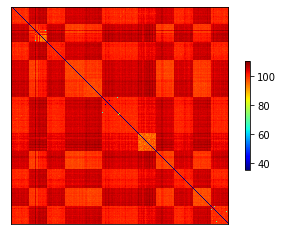

In [47]:
fig, ax = plt.subplots()
allel.plot_pairwise_distance(dist_3R, ax=ax)
plt.savefig("pairwise_distance_west_3R.pdf")

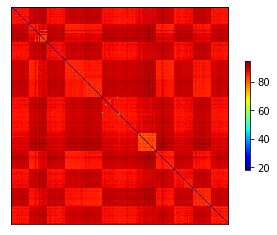

In [48]:
fig, ax = plt.subplots()
allel.plot_pairwise_distance(dist_3L, ax=ax)
plt.savefig("pairwise_distance_west_3L.pdf")

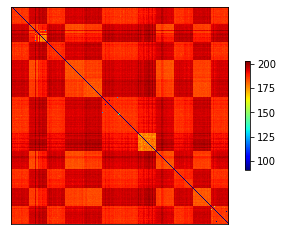

In [49]:
fig, ax = plt.subplots()
allel.plot_pairwise_distance(dist_3R+dist_3L, ax=ax)
plt.savefig("pairwise_distance_west_3R+3L.pdf")

## Phase 3 - Test - gamb

In [140]:
sidx, sub_sidx = load_tbl_samples_sub(west_gamb_populations, 14, df_west_gamb, max_population_size = 20)

In [141]:
dist_3R = comp_dist('3R', 'gamb_colu', sidx, sample_sets_west)
dist_3L = comp_dist('3L', 'gamb_colu', sidx, sample_sets_west)

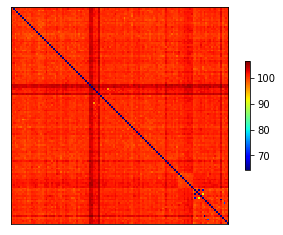

In [142]:
fig, ax = plt.subplots()
allel.plot_pairwise_distance(dist_3R, ax=ax)
plt.savefig("pairwise_distance_gamb_3R.pdf")

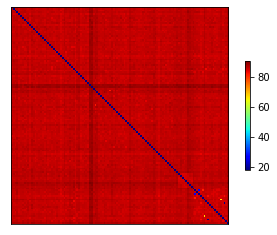

In [143]:
fig, ax = plt.subplots()
allel.plot_pairwise_distance(dist_3L, ax=ax)
plt.savefig("pairwise_distance_gamb_3L.pdf")

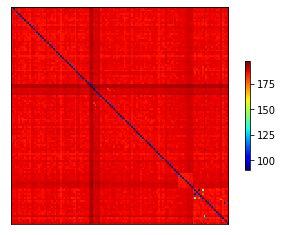

In [144]:
fig, ax = plt.subplots()
allel.plot_pairwise_distance(dist_3R+dist_3L, ax=ax)
plt.savefig("pairwise_distance_gamb_3R+3L.pdf")

## Phase 3 - Test - colu

In [143]:
sidx, sub_sidx = load_tbl_samples_sub(west_col_populations, 14, df_west_col, max_population_size = 20)

In [144]:
dist_3R = comp_dist('3R', 'gamb_colu', sidx, sample_sets_west)
dist_3L = comp_dist('3L', 'gamb_colu', sidx, sample_sets_west)

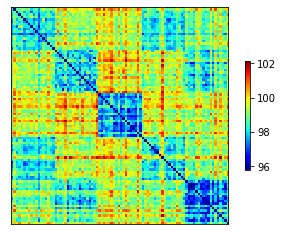

In [145]:
fig, ax = plt.subplots()
allel.plot_pairwise_distance(dist_3R, ax=ax)
plt.savefig("pairwise_distance_colu_3R.pdf")

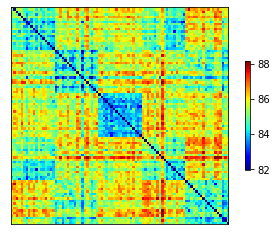

In [146]:
fig, ax = plt.subplots()
allel.plot_pairwise_distance(dist_3L, ax=ax)
plt.savefig("pairwise_distance_colu_3L.pdf")

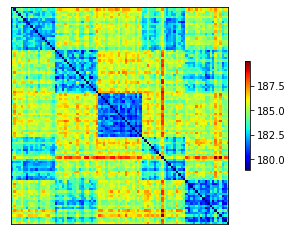

In [147]:
fig, ax = plt.subplots()
allel.plot_pairwise_distance(dist_3R+dist_3L, ax=ax)
plt.savefig("pairwise_distance_colu_3R+3L.pdf")

## Phase 3 - Test - west + balloon

In [43]:
sidx, sub_sidx = load_tbl_samples_sub(west_balloon_populations, 14, df_west_balloon, max_population_size = 23)
df_samples_sub = pd.concat([df_west_balloon[df_west_balloon.index.isin(sub_sidx[p])] for p in west_balloon_populations])
df_samples_sub.reset_index(drop=True, inplace=True)

In [44]:
dist_3R = comp_dist('3R', 'gamb_colu', sidx, sample_sets_west + ["1177-VO-ML-LEHMANN-VMF00015"])
dist_3L = comp_dist('3L', 'gamb_colu', sidx, sample_sets_west + ["1177-VO-ML-LEHMANN-VMF00015"])

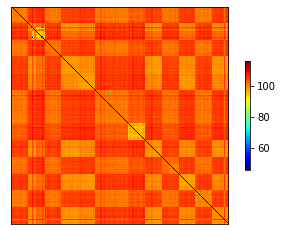

In [45]:
fig, ax = plt.subplots()
allel.plot_pairwise_distance(dist_3R, ax=ax)
plt.savefig("pairwise_distance_west_balloon_3R.pdf")

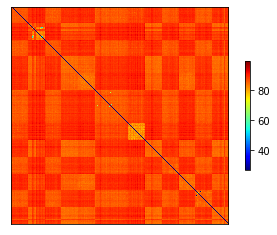

In [46]:
fig, ax = plt.subplots()
allel.plot_pairwise_distance(dist_3L, ax=ax)
plt.savefig("pairwise_distance_west_balloon_3L.pdf")

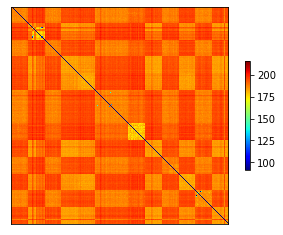

In [47]:
fig, ax = plt.subplots()
allel.plot_pairwise_distance(dist_3L+dist_3R, ax=ax)
plt.savefig("pairwise_distance_west_balloon_3R+3L.pdf")

<AxesSubplot:ylabel='sample_id'>

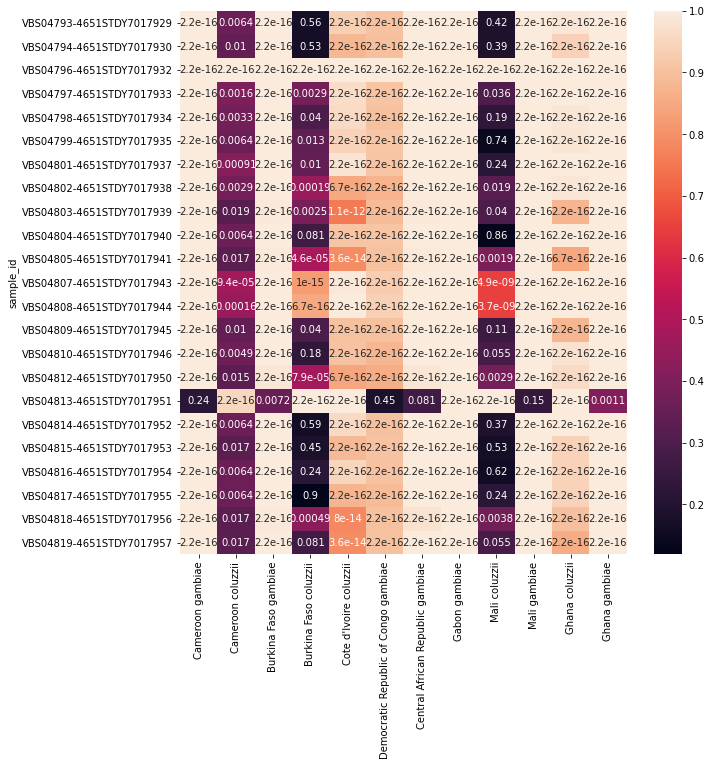

In [48]:
sub_ids = {pop: list(df_samples_sub[df_samples_sub.population == pop].index) for pop in west_populations}

within_distance = {pop: (dist_3R+dist_3L)[allel.condensed_coords_within(sub_ids[pop], len(sidx))] for pop in west_populations}

n_pop_ref = len(west_populations)
n_q_samples = len(df_all_balloon)
first_balloon_id = df_samples_sub[df_samples_sub.population == "Balloon"].index[0]
score_all = np.zeros((n_q_samples, n_pop_ref))
p_val_all = np.zeros((n_q_samples, n_pop_ref))

for i in range(0, n_q_samples):
    for j, pop in enumerate(west_populations):
        score_all[i,j], p_val_all[i,j] = stats.kstest((dist_3L+dist_3R)[allel.condensed_coords_between([i + first_balloon_id], sub_ids[pop], len(sidx))],
             within_distance[pop])
        

score_all_df = pd.DataFrame(data=score_all, index=df_all_balloon.sample_id, columns=west_populations)

fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(score_all_df, annot=p_val_all, ax=ax)

## Phase 3 - Test - gamb + balloon

In [49]:
sidx, sub_sidx = load_tbl_samples_sub(west_gamb_balloon_populations, 14, df_west_gamb_balloon, max_population_size = 23)
df_samples_sub = pd.concat([df_west_gamb_balloon[df_west_gamb_balloon.index.isin(sub_sidx[p])] for p in west_gamb_balloon_populations])
df_samples_sub.reset_index(drop=True, inplace=True)

In [50]:
dist_3R = comp_dist('3R', 'gamb_colu', sidx, sample_sets_west + ["1177-VO-ML-LEHMANN-VMF00015"])
dist_3L = comp_dist('3L', 'gamb_colu', sidx, sample_sets_west + ["1177-VO-ML-LEHMANN-VMF00015"])

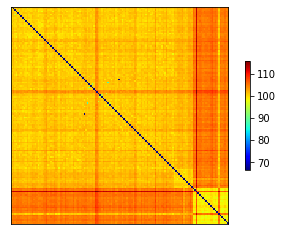

In [51]:
fig, ax = plt.subplots()
allel.plot_pairwise_distance(dist_3R, ax=ax)
plt.savefig("pairwise_distance_gamb_balloon_3R.pdf")

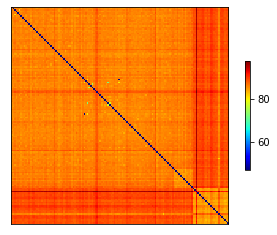

In [52]:
fig, ax = plt.subplots()
allel.plot_pairwise_distance(dist_3L, ax=ax)
plt.savefig("pairwise_distance_gamb_balloon_3L.pdf")

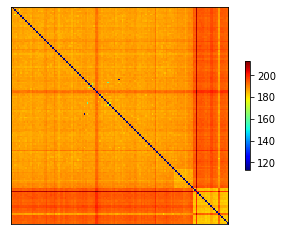

In [53]:
fig, ax = plt.subplots()
allel.plot_pairwise_distance(dist_3L+dist_3R, ax=ax)
plt.savefig("pairwise_distance_gamb_balloon_3R+3L.pdf")

<AxesSubplot:ylabel='sample_id'>

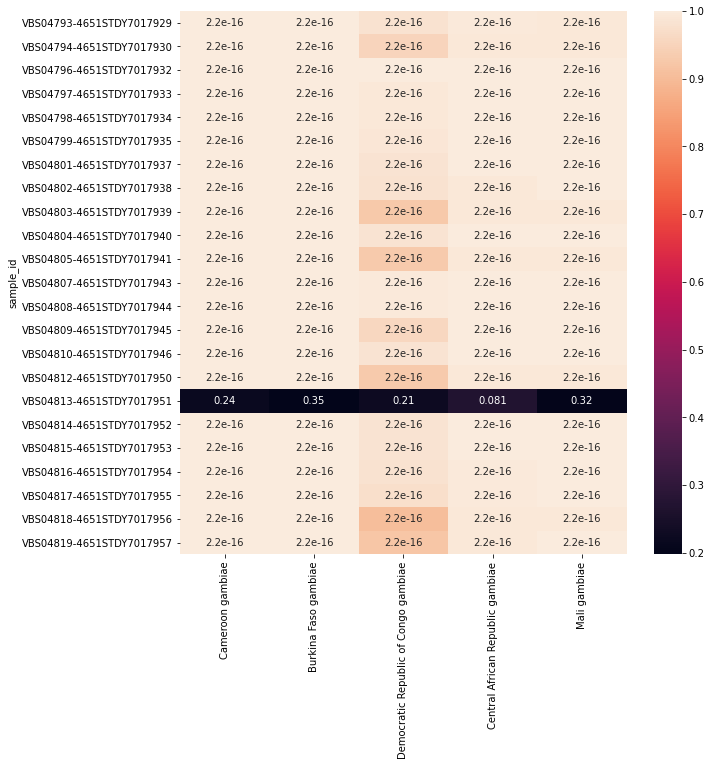

In [54]:
sub_ids = {pop: list(df_samples_sub[df_samples_sub.population == pop].index) for pop in west_gamb_populations}

within_distance = {pop: (dist_3R+dist_3L)[allel.condensed_coords_within(sub_ids[pop], len(sidx))] for pop in west_gamb_populations}

n_pop_ref = len(west_gamb_populations)
n_q_samples = len(df_all_balloon)
first_balloon_id = df_samples_sub[df_samples_sub.population == "Balloon"].index[0]
score_all = np.zeros((n_q_samples, n_pop_ref))
p_val_all = np.zeros((n_q_samples, n_pop_ref))

for i in range(0, n_q_samples):
    for j, pop in enumerate(west_gamb_populations):
        score_all[i,j], p_val_all[i,j] = stats.kstest((dist_3L+dist_3R)[allel.condensed_coords_between([i + first_balloon_id], sub_ids[pop], len(sidx))],
             within_distance[pop])

score_all_df = pd.DataFrame(data=score_all, index=df_all_balloon.sample_id, columns=west_gamb_populations)

fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(score_all_df, annot=p_val_all, ax=ax)

## Phase 3 - Test - colu + balloon

In [55]:
sidx, sub_sidx = load_tbl_samples_sub(west_col_balloon_populations, 14, df_west_col_balloon, max_population_size = 23)
df_samples_sub = pd.concat([df_west_col_balloon[df_west_col_balloon.index.isin(sub_sidx[p])] for p in west_col_balloon_populations])
df_samples_sub.reset_index(drop=True, inplace=True)

In [56]:
dist_3R = comp_dist('3R', 'gamb_colu', sidx, sample_sets_west + ["1177-VO-ML-LEHMANN-VMF00015"])
dist_3L = comp_dist('3L', 'gamb_colu', sidx, sample_sets_west + ["1177-VO-ML-LEHMANN-VMF00015"])

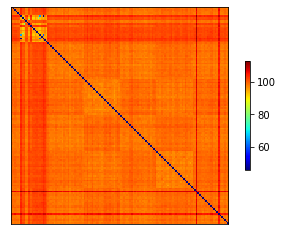

In [57]:
fig, ax = plt.subplots()
allel.plot_pairwise_distance(dist_3R, ax=ax)
plt.savefig("pairwise_distance_colu_balloon_3R.pdf")

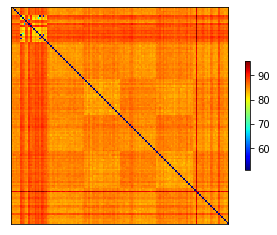

In [58]:
fig, ax = plt.subplots()
allel.plot_pairwise_distance(dist_3L, ax=ax)
plt.savefig("pairwise_distance_colu_balloon_3L.pdf")

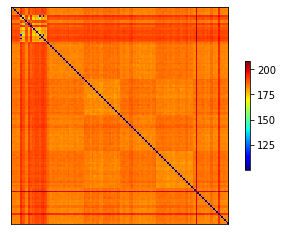

In [59]:
fig, ax = plt.subplots()
allel.plot_pairwise_distance(dist_3L+dist_3R, ax=ax)
plt.savefig("pairwise_distance_colu_balloon_3R+3L.pdf")

<AxesSubplot:ylabel='sample_id'>

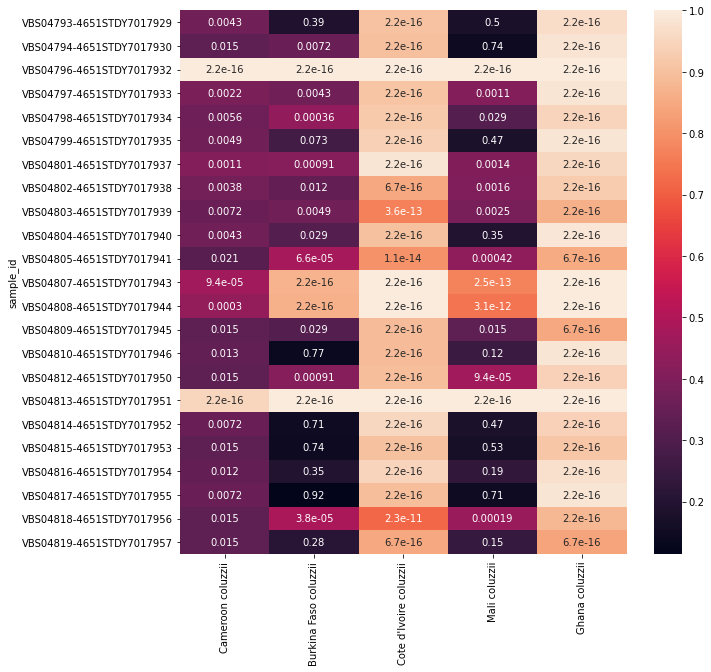

In [60]:
sub_ids = {pop: list(df_samples_sub[df_samples_sub.population == pop].index) for pop in west_col_balloon_populations[:-1]}

within_distance = {pop: (dist_3R+dist_3L)[allel.condensed_coords_within(sub_ids[pop], len(sidx))] for pop in west_col_balloon_populations[:-1]}

n_pop_ref = len(west_col_balloon_populations[:-1])
n_q_samples = len(df_all_balloon)
first_balloon_id = df_samples_sub[df_samples_sub.population == "Balloon"].index[0]
score_all = np.zeros((n_q_samples, n_pop_ref))
p_val_all = np.zeros((n_q_samples, n_pop_ref))

for i in range(0, n_q_samples):
    for j, pop in enumerate(west_col_balloon_populations[:-1]):
        score_all[i,j], p_val_all[i,j] = stats.kstest((dist_3L+dist_3R)[allel.condensed_coords_between([i + first_balloon_id], sub_ids[pop], len(sidx))],
             within_distance[pop])

score_all_df = pd.DataFrame(data=score_all, index=df_all_balloon.sample_id, columns=west_col_balloon_populations[:-1])

fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(score_all_df, annot=p_val_all, ax=ax)

## Reference check

In [55]:
sidx, sub_sidx = load_tbl_samples_sub(west_populations, 14, df_west, max_population_size = 20)

In [57]:
gamb_ref = list(df_west[df_west.population == 'Mali gambiae'].index)
for i in sub_sidx['Mali gambiae']:
    gamb_ref.remove(i)

46

In [65]:
sidx = sidx + gamb_ref

In [66]:
sub_sidx['Mali gambiae ref'] = gamb_ref

In [85]:
df_samples_sub = pd.concat([df_west[df_west.index.isin(sub_sidx[p])] for p in west_populations])
gamb_ref_df = df_west[df_west.index.isin(sub_sidx['Mali gambiae ref'])].copy()
gamb_ref_df['population'] = ['Mali gambiae ref' for i in df_west[df_west.index.isin(sub_sidx['Mali gambiae ref'])].index]
df_samples_sub = df_samples_sub.append(gamb_ref_df)
df_samples_sub.reset_index(drop=True, inplace=True)

In [69]:
dist_3R = comp_dist('3R', 'gamb_colu', sidx, sample_sets_west)
dist_3L = comp_dist('3L', 'gamb_colu', sidx, sample_sets_west)

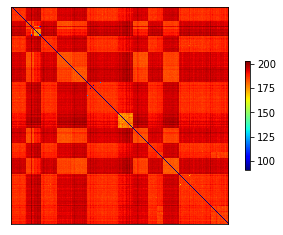

In [70]:
fig, ax = plt.subplots()
allel.plot_pairwise_distance(dist_3L+dist_3R, ax=ax)
plt.savefig("pairwise_distance_test_ref_3R+3L.pdf")

In [88]:
sub_ids = {pop: list(df_samples_sub[df_samples_sub.population == pop].index) for pop in west_populations}

within_distance = {pop: (dist_3R+dist_3L)[allel.condensed_coords_within(sub_ids[pop], len(sidx))] for pop in west_populations}

n_pop_ref = len(west_populations)
n_q_samples = len(gamb_ref)
first_balloon_id = df_samples_sub[df_samples_sub.population == 'Mali gambiae ref'].index[0]
score_all = np.zeros((n_q_samples, n_pop_ref))

for i in range(0, n_q_samples):
    for j, pop in enumerate(west_populations):
        score_all[i,j] = stats.kstest((dist_3L+dist_3R)[allel.condensed_coords_between([i + first_balloon_id], sub_ids[pop], len(sidx))],
             within_distance[pop])[0]

<AxesSubplot:ylabel='sample_id'>

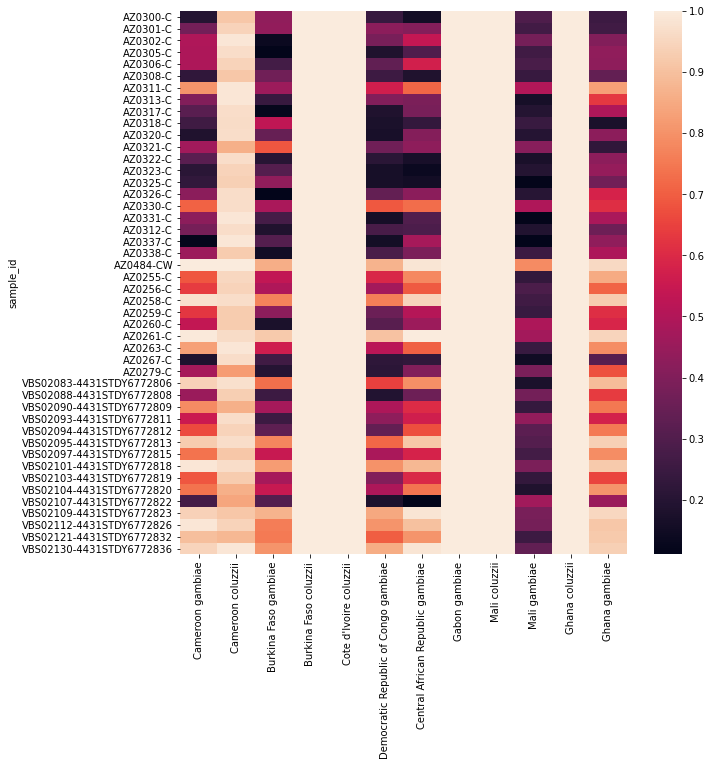

In [92]:
score_all_df = pd.DataFrame(data=score_all, index=df_samples_sub[df_samples_sub.population == 'Mali gambiae ref'].sample_id, columns=west_populations)

fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(score_all_df, annot=False, ax=ax)

In [93]:
sidx, sub_sidx = load_tbl_samples_sub(west_gamb_populations, 14, df_west_gamb, max_population_size = 20)

In [94]:
gamb_ref = list(df_west[df_west.population == 'Mali gambiae'].index)
for i in sub_sidx['Mali gambiae']:
    gamb_ref.remove(i)

In [95]:
sidx = sidx + gamb_ref

In [96]:
sub_sidx['Mali gambiae ref'] = gamb_ref

In [97]:
df_samples_sub = pd.concat([df_west_gamb[df_west_gamb.index.isin(sub_sidx[p])] for p in west_gamb_populations])
gamb_ref_df = df_west_gamb[df_west_gamb.index.isin(sub_sidx['Mali gambiae ref'])].copy()
gamb_ref_df['population'] = ['Mali gambiae ref' for i in df_west_gamb[df_west_gamb.index.isin(sub_sidx['Mali gambiae ref'])].index]
df_samples_sub = df_samples_sub.append(gamb_ref_df)
df_samples_sub.reset_index(drop=True, inplace=True)

In [98]:
dist_3R = comp_dist('3R', 'gamb_colu', sidx, sample_sets_west)
dist_3L = comp_dist('3L', 'gamb_colu', sidx, sample_sets_west)

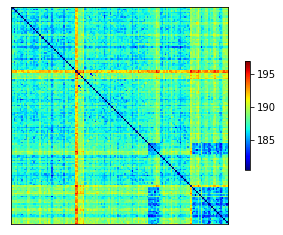

In [99]:
fig, ax = plt.subplots()
allel.plot_pairwise_distance(dist_3L+dist_3R, ax=ax)
plt.savefig("pairwise_distance_test_ref_3R+3L.pdf")

In [100]:
sub_ids = {pop: list(df_samples_sub[df_samples_sub.population == pop].index) for pop in west_gamb_populations}

within_distance = {pop: (dist_3R+dist_3L)[allel.condensed_coords_within(sub_ids[pop], len(sidx))] for pop in west_gamb_populations}

n_pop_ref = len(west_gamb_populations)
n_q_samples = len(gamb_ref)
first_balloon_id = df_samples_sub[df_samples_sub.population == 'Mali gambiae ref'].index[0]
score_all = np.zeros((n_q_samples, n_pop_ref))

for i in range(0, n_q_samples):
    for j, pop in enumerate(west_gamb_populations):
        score_all[i,j] = stats.kstest((dist_3L+dist_3R)[allel.condensed_coords_between([i + first_balloon_id], sub_ids[pop], len(sidx))],
             within_distance[pop])[0]

<AxesSubplot:ylabel='sample_id'>

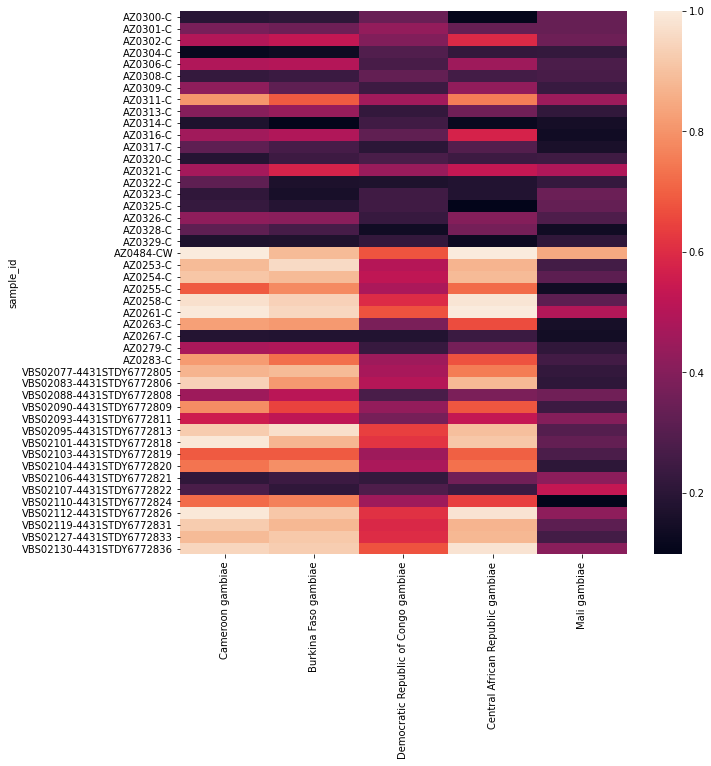

In [101]:
score_all_df = pd.DataFrame(data=score_all, index=df_samples_sub[df_samples_sub.population == 'Mali gambiae ref'].sample_id, columns=west_gamb_populations)

fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(score_all_df, annot=False, ax=ax)

# Classifier

<AxesSubplot:ylabel='sample_id'>

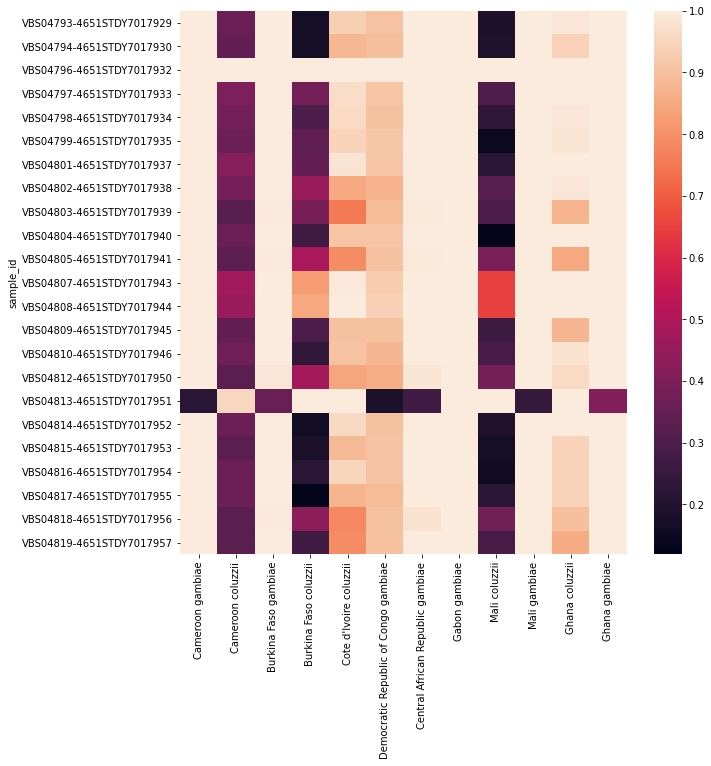

In [100]:
sub_ids = {pop: list(df_samples_sub[df_samples_sub.population == pop].index) for pop in west_populations}

within_distance = {pop: (dist_3R+dist_3L)[allel.condensed_coords_within(sub_ids[pop], len(sidx))] for pop in west_populations}

n_pop_ref = len(west_populations)
n_q_samples = len(df_all_balloon)
first_balloon_id = df_samples_sub[df_samples_sub.population == "Balloon"].index[0]
score_all = np.zeros((n_q_samples, n_pop_ref))

for i in range(0, n_q_samples):
    for j, pop in enumerate(west_populations):
        score_all[i,j] = stats.kstest((dist_3L+dist_3R)[allel.condensed_coords_between([i + first_balloon_id], sub_ids[pop], len(sidx))],
             within_distance[pop])[0]

score_all_df = pd.DataFrame(data=score_all, index=df_all_balloon.sample_id, columns=west_populations)

fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(score_all_df, annot=False, ax=ax)

In [87]:
df_all_balloon.sample_id

1269    VBS04793-4651STDY7017929
1270    VBS04794-4651STDY7017930
1271    VBS04796-4651STDY7017932
1272    VBS04797-4651STDY7017933
1273    VBS04798-4651STDY7017934
1274    VBS04799-4651STDY7017935
1275    VBS04801-4651STDY7017937
1276    VBS04802-4651STDY7017938
1277    VBS04803-4651STDY7017939
1278    VBS04804-4651STDY7017940
1279    VBS04805-4651STDY7017941
1280    VBS04807-4651STDY7017943
1281    VBS04808-4651STDY7017944
1282    VBS04809-4651STDY7017945
1283    VBS04810-4651STDY7017946
1284    VBS04812-4651STDY7017950
1285    VBS04813-4651STDY7017951
1286    VBS04814-4651STDY7017952
1287    VBS04815-4651STDY7017953
1288    VBS04816-4651STDY7017954
1289    VBS04817-4651STDY7017955
1290    VBS04818-4651STDY7017956
1291    VBS04819-4651STDY7017957
Name: sample_id, dtype: object

In [54]:
stats.kstest((dist_3L+dist_3R)[allel.condensed_coords_between([298], sub_ids[west_populations[0]], len(sidx))],
             within_distance[west_populations[0]])

KstestResult(statistic=1.0, pvalue=2.220446049250313e-16)

In [56]:
stats.kstest((dist_3L+dist_3R)[allel.condensed_coords_between([298], sub_ids[west_populations[1]], len(sidx))],
             within_distance[west_populations[1]])

KstestResult(statistic=0.32806324110671936, pvalue=0.016822472589031245)

In [55]:
dist_3L[allel.condensed_coords_within(range(0,20), len(sidx))]

array([86.10458757, 85.79044236, 86.3539229 , 85.77878526, 86.3539229 ,
       85.15867542, 85.45759182, 85.10581649, 85.39906323, 85.20563362,
       86.37129153, 85.74380444, 85.54530963, 84.7761759 , 85.5628424 ,
       85.83122975, 85.7554663 , 85.67963585, 86.22644606, 85.34635317,
       86.28441342, 84.56949805, 86.21484791, 86.60254038, 86.21484791,
       85.90110593, 85.52777327, 86.02325267, 86.7986175 , 85.98837131,
       85.40491789, 85.15280383, 85.73797292, 85.92438536, 85.65045242,
       85.5628424 , 86.36550237, 85.93602271, 84.78207358, 85.73797292,
       86.37129153, 86.67756342, 85.46929273, 85.6562899 , 85.59205571,
       85.86035173, 86.27861844, 85.33463541, 86.21484791, 85.83122975,
       85.86617495, 85.84870413, 85.57452892, 85.88946385, 85.48099204,
       86.52167359, 86.46964785, 86.83317338, 86.20904825, 86.06973917,
       85.5628424 , 86.64294547, 86.42337647, 86.27282307, 85.93020424,
       86.82165628, 86.55634003, 85.92438536, 85.61541917, 85.89

In [57]:
dist_3L[allel.condensed_coords_within(range(20,40), len(sidx))]

array([84.60496439, 83.77947243, 83.99404741, 84.68175719, 84.1011296 ,
       87.97726979, 87.1894489 , 84.85281374, 83.78544026, 86.29600222,
       85.67963585, 86.69486721, 86.28441342, 87.46427842, 86.94250974,
       88.32893071, 86.45808233, 87.26396736, 86.4985549 , 84.9411561 ,
       84.79976415, 85.37564055, 84.90583019, 88.64536085, 88.02272434,
       85.86035173, 84.48668534, 88.02840451, 87.44712688, 87.08616423,
       86.42337647, 88.75809822, 87.90335602, 88.43076388, 87.14929719,
       88.2892972 , 86.61408661, 84.04760556, 85.24083528, 84.55767263,
       88.66228059, 87.98295289, 85.18802733, 84.78797084, 87.1894489 ,
       87.06319544, 87.03447593, 87.07468059, 88.72992731, 87.32697178,
       88.57200461, 86.55634003, 88.        , 87.26396736, 84.42748368,
       84.39194274, 88.09653796, 87.44712688, 85.85452813, 84.63450833,
       87.12060606, 87.1894489 , 86.79285685, 86.87922652, 88.95504483,
       87.50999943, 88.32326987, 86.5909926 , 87.66983518, 86.64

In [58]:
dist_3L[range(0,40)]

array([86.10458757, 85.79044236, 86.3539229 , 85.77878526, 86.3539229 ,
       85.15867542, 85.45759182, 85.10581649, 85.39906323, 85.20563362,
       86.37129153, 85.74380444, 85.54530963, 84.7761759 , 85.5628424 ,
       85.83122975, 85.7554663 , 85.67963585, 86.22644606, 88.28363382,
       88.94942383, 89.43712876, 88.59458223, 88.72992731, 88.68483523,
       91.55326319, 89.83317873, 89.11789944, 89.05054744, 89.47066558,
       90.68075871, 89.42035562, 89.21322772, 90.73036978, 90.03888049,
       90.35485598, 89.68277427, 90.73588044, 89.63258336, 85.21150157])